In [85]:
import pandas as pd
import numpy as np

In [86]:
df = pd.read_csv('data/development.csv').set_index('Id')
df.head()

df.drop(['sampling_rate', 'path', 'num_characters'], axis=1, inplace=True)
df['tempo'] = df['tempo'].apply(lambda x: x.replace('[', '').replace(']', '')).astype('float')
df.drop('ethnicity', axis=1, inplace=True)
gender =  {'male': 1, 'female': 0, "famale": 0}
df['gender'] = df['gender'].map(gender)


from sklearn.model_selection import train_test_split
X = df.drop('age', axis=1)
y = df['age']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
from sklearn.ensemble import IsolationForest

# Selezioniamo solo le colonne numeriche per l'analisi degli outlier
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
X_train_numeric = X_train[numeric_columns]

# Creiamo il modello Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X_train_numeric)

# Aggiungiamo una colonna al dataframe di addestramento per indicare gli outlier
X_train['outlier'] = outliers

# Visualizziamo i primi 5 outlier
X_train[X_train['outlier'] == -1].head()

,gender,mean_pitch,max_pitch,min_pitch,jitter,shimmer,energy,zcr_mean,spectral_centroid_mean,tempo,hnr,num_words,num_pauses,silence_duration,outlier
Id,,,,,,,,,,,,,,,
867,0,731.10430,2617.0647,157.80966,0.013942,0.065388,0.003862,0.038818,1068.176073,92.285156,-54.767539,0,2,1.767891,-1
157,0,1558.02310,3984.5176,179.93149,0.013089,0.062885,0.000410,0.086549,2234.083709,89.102909,-34.446052,4,1,2.110522,-1
315,1,585.11660,3176.6228,148.07552,0.024021,0.058867,0.016687,0.047919,1730.583283,234.907670,-54.642575,3,2,1.142540,-1
2596,1,560.27734,1486.8151,145.58300,0.025139,0.094151,0.003954,0.038484,2516.856624,143.554688,-108.050537,2,4,2.391655,-1
208,1,938.62050,3197.5447,147.58461,0.027052,0.124993,0.002469,0.079009,2873.017945,215.332031,-87.502412,4,1,2.410385,-1


In [88]:
X_train[X_train['outlier'] == -1].count()

gender                    118
mean_pitch                118
max_pitch                 118
min_pitch                 118
jitter                    118
shimmer                   118
energy                    118
zcr_mean                  118
spectral_centroid_mean    118
tempo                     118
hnr                       118
num_words                 118
num_pauses                118
silence_duration          118
outlier                   118
dtype: int64

In [89]:
df_no_outliers = X_train[X_train['outlier'] != -1]
y_train_no_outliers = y_train[X_train['outlier'] != -1]
df_no_outliers.drop('outlier', axis=1, inplace=True)

C:\Users\lucad\AppData\Local\Temp\ipykernel_13456\2684111946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers.drop('outlier', axis=1, inplace=True)


In [90]:
from  sklearn.preprocessing import StandardScaler
from  sklearn.neural_network import  MLPRegressor

# Creiamo il modello di regressione Ridge
scaler = StandardScaler()
ridge = MLPRegressor()

X_s = scaler.fit_transform(df_no_outliers)
ridge.fit(X_s, y_train_no_outliers)

# Valutiamo il modello  
X_test_numeric = X_test[numeric_columns]    
X_test['outlier'] = iso_forest.predict(X_test_numeric)  
X_test_no_outliers = X_test[X_test['outlier'] != -1]
y_test_no_outliers = y_test[X_test['outlier'] != -1]    
X_test_no_outliers.drop('outlier', axis=1, inplace=True)    
X_test_s = scaler.transform(X_test_no_outliers) 
y_pred = ridge.predict(X_test_s)

from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_test_no_outliers, y_pred)
print(f'RMSE: {rmse}')  



RMSE: 10.351809866022474


c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\lucad\AppData\Local\Temp\ipykernel_13456\2785725526.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_no_outliers.drop('outlier', axis=1, inplace=True)


In [91]:
# Combina i dataset di addestramento e di test
X_combined = pd.concat([df_no_outliers, X_test_no_outliers])
y_combined = pd.concat([y_train_no_outliers, y_test_no_outliers])

# Scala i dati combinati
X_combined_scaled = scaler.fit_transform(X_combined)

# Allena il modello sui dati combinati
ridge.fit(X_combined_scaled, y_combined)

# Valuta il modello sui dati combinati
y_combined_pred = ridge.predict(X_combined_scaled)

# Calcola l'RMSE sui dati combinati
rmse_combined = np.sqrt(np.mean((y_combined - y_combined_pred) ** 2))
print(f'RMSE sui dati combinati: {rmse_combined}')

RMSE sui dati combinati: 10.500241676872498


c:\Users\lucad\miniforge3\envs\dsl\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [92]:
df = pd.read_csv('data/evaluation.csv').set_index('Id')
df.drop(['sampling_rate', 'path', 'num_characters'], axis=1, inplace=True)
df['tempo'] = df['tempo'].apply(lambda x: x.replace('[', '').replace(']', '')).astype('float')
df.drop('ethnicity', axis=1, inplace=True)
gender =  {'male': 1, 'female': 0, "famale": 0}
df['gender'] = df['gender'].map(gender)

Xs = scaler.transform(df)
y_pred = ridge.predict(Xs)

output = pd.DataFrame({'Id': df.index, 'Predicted': y_pred}).to_csv('out/age.csv', index=False)

In [93]:
min(y_combined), max(y_combined), min(y_pred), max(y_pred)  

(6.0, 97.0, np.float64(13.589251582261666), np.float64(50.92927071661239))

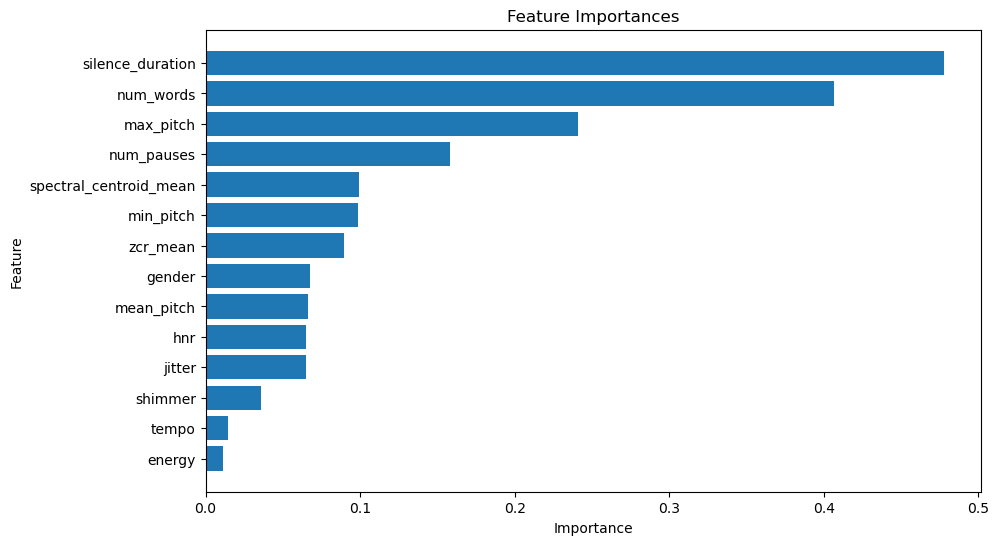

In [94]:
from sklearn.inspection import permutation_importance

# Calcola l'importanza delle feature usando la permutazione
result = permutation_importance(ridge, X_test_s, y_test_no_outliers, n_repeats=10, random_state=42, n_jobs=-1)

# Crea un DataFrame per visualizzare meglio i risultati
feature_importances = pd.DataFrame({'Feature': df_no_outliers.columns, 'Importance': result.importances_mean})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot delle importanze delle feature
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()


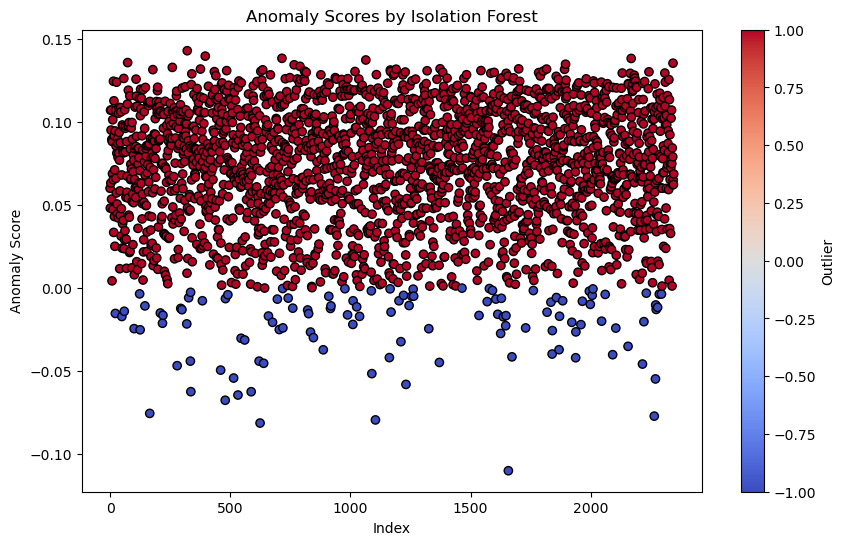

In [97]:
import matplotlib.pyplot as plt

# Calcola i punteggi di anomalia per i dati di addestramento
anomaly_scores = iso_forest.decision_function(X_train_numeric)

# Crea un grafico a dispersione dei punteggi di anomalia
plt.figure(figsize=(10, 6))
plt.scatter(range(len(anomaly_scores)), anomaly_scores, c=outliers, cmap='coolwarm', edgecolor='k')
plt.xlabel('Index')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Scores by Isolation Forest')
plt.colorbar(label='Outlier')
plt.show()